#Sentiment Analaysis NLP Workshop


## Environment Setup

In this workshop, we will work on a sentiment analysis task. Before we get started, you need to install transformers. Let us get it out of the way before we dive in.

In [1]:
# First, we need to setup our environment by changing runtime to gpu
import torch
torch.cuda.is_available()

False

In [2]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (3.5.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


Next, we have to get a personal access token from huggingface:

In [2]:
from huggingface_hub import notebook_login
notebook_login()

Now Think about creating a repository, you will be using it in this lab

## Demo

Write the demo code here

In [ ]:
from transformers import pipeline
model_name = "bert-base-uncased"
sentiment_classifier = pipeline("sentiment-analysis", model=model_name)
text ="I love this movie"
result = sentiment_classifier(text)
print("text:", text)
print("Sentiment:", result[0]['label'], "Confidence: ", result[0]['score'])

/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSe

text: I love this movie
Sentiment: LABEL_1 Confidence:  0.6069915294647217


In [6]:
text ="This movie is really bad"
result = sentiment_classifier(text)
print("text:", text)
print("Sentiment:", result[0]['label'], "Confidence: ", result[0]['score'])

text: This movie is really bad
Sentiment: LABEL_1 Confidence:  0.5883337259292603


## Getting the Data

In this tutorial, you'll use the IMDB dataset to fine-tune a DistilBERT model for sentiment analysis.

The IMDB dataset contains 25,000 movie reviews labeled by sentiment for training a model and 25,000 movie reviews for testing it. You'll use the IMDB dataset to fine-tune a BERT model that is able to classify whether a movie review is positive or negative. Once you train the model, you will use it to analyze new data! ⚡️

In [3]:
from datasets import load_dataset
imdb = load_dataset("imdb")

## Splitting the Data

In [4]:
# Create a smaller training dataset for faster training times
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])
# Print an example of each
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

## Pre-processing

In [5]:
# Import tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Prepare the text inputs for the model
def preprocess_function(exemples):
    return tokenizer(exemples["text"], truncation = True)

tokenized_train = small_train_dataset.map(preprocess_function, batched = True)
tokenized_test = small_test_dataset.map(preprocess_function, batched = True)

In [7]:
# Use data_collector to convert our samples to PyTorch tensors and concatenate them with the correct amount of padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [8]:
# import the pre-trained model
from transformers import AutoModelForSequenceClassification
model  = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

## Defining Accuracy Metrics

For this task, we wil be using two accuracy metrics: Accuracy and F1 score:

* Accuracy is the proportion of correct predictions among the total number of
cases processed. It can be computed with: Accuracy = (TP + TN) / (TP + TN + FP + FN) Where: TP: True positive TN: True negative FP: False positive FN: False negative
* The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation: F1 = 2 * (precision * recall) / (precision + recall)

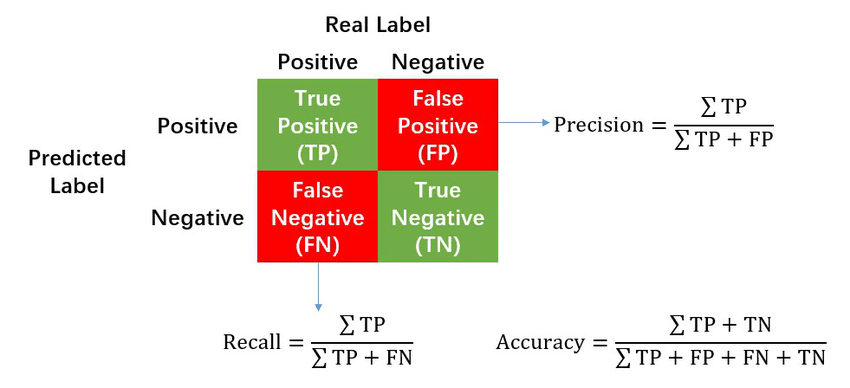![image.png](
  
)

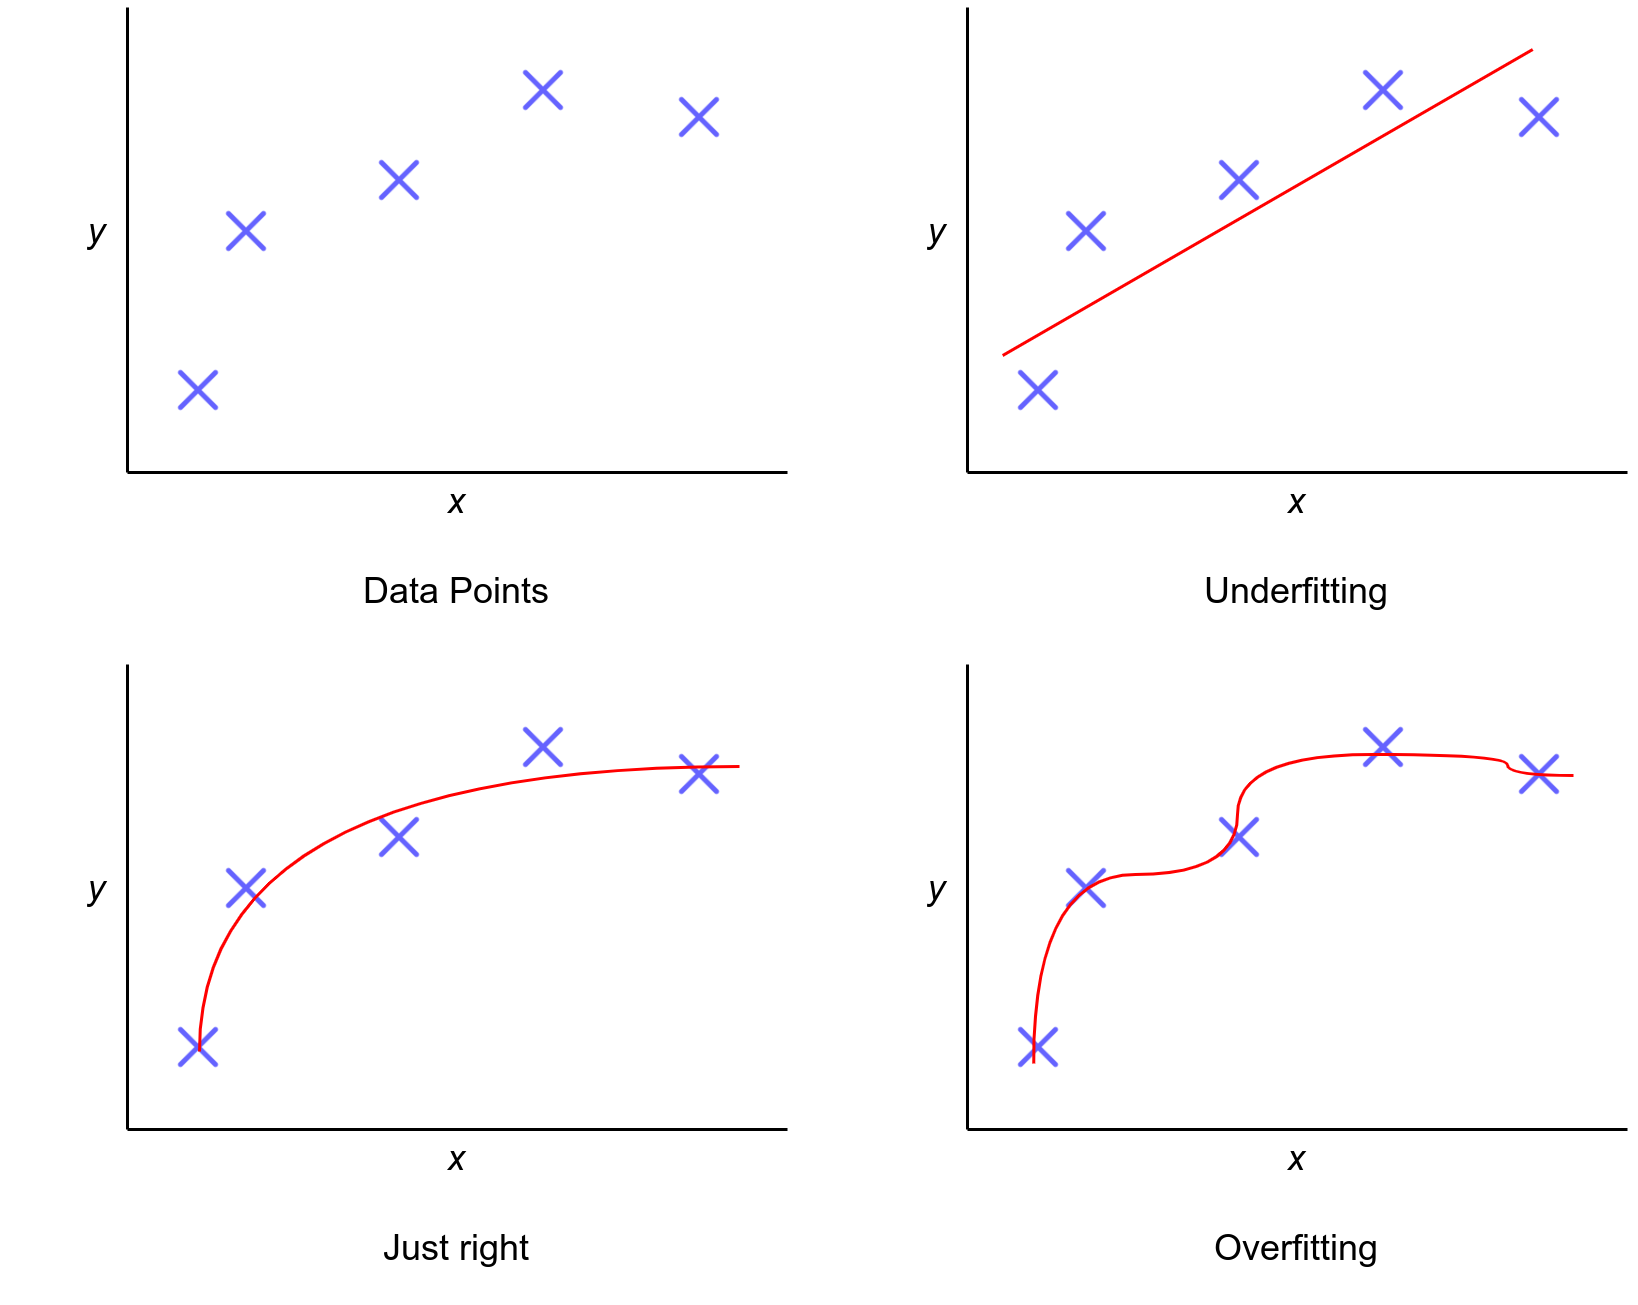

In [9]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

## Training BERT 🚀

 DistilBERT is a smaller, faster and cheaper version of BERT. It has 40% smaller than BERT and runs 60% faster while preserving over 95% of BERT’s performance.

In [10]:
from transformers import TrainingArguments, Trainer

repo_name = "A-new-repo" # name of the repo

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/workspaces/NLP-with-HuggingFace/A-new-repo is already a clone of https://huggingface.co/AliMokh/A-new-repo. Make sure you pull the latest changes with `repo.git_pull()`.


In [11]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/tmp/ipykernel_2199/284421109.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/workspaces/NLP-with-HuggingFace/HF_SA_MLOps/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which

{'eval_loss': 0.695636510848999,
 'eval_accuracy': 0.5,
 'eval_f1': 0.6666666666666666,
 'eval_runtime': 186.1263,
 'eval_samples_per_second': 1.612,
 'eval_steps_per_second': 0.102}

In [ ]:
trainer.push_to_hub()

# Testing the pipeline

In the IMDB dataset, Label 1 means positive and Label 0 is negative. Quite good! 🔥